<a href="https://colab.research.google.com/github/johnhallman/ctsb/blob/tutorials/tutorials/notebooks/QuickStart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quickstart into CTSB

Welcome to CTSB! This is a short tutorial to get you started with the framework. First, start by installing the package from GitHub using pip or pip3.

In [0]:
!git clone https://github.com/johnhallman/ctsb.git
!pip install -e ctsb

Import CTSB as with any other Python package

In [0]:
import ctsb
ctsb.set_key(0) # random seeding makes CTSB deterministic

/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


You are now ready to get started!

# The Problem class
The Problem class is the abstraction used to implement control and time series tasks. CTSB comes pre-loaded with several classical problems (both simulated and real world data) such as ARMA time series or linear dynamical systems. Below we demonstrate how to initialize a problem and step through the simulated time series generated by an ARMA. The initialize() method returns the initial observation. We can also query the hidden state of the system.


Hidden state: (DeviceArray([ 0.41282263,  0.03539855, -0.11903672], dtype=float32), DeviceArray([-0.8611955 , -0.56147075,  1.61942554], dtype=float32))


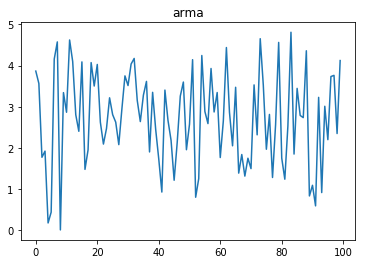

In [0]:
import jax.numpy as np
import matplotlib.pyplot as plt

# create a time-series problem instance
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
problem.initialize(p,q)

# run problem for T time-steps
test_output = []
for t in range(T):
    test_output.append(problem.step())
    
hidden = problem.hidden()
print("Hidden state: {}".format(hidden))

# plot the resulting time-series
plt.plot(test_output)
plt.title("arma")
plt.show()

The help() method provides more info about the API of a certain Problem class.

In [0]:
problem.help()



-------------------- *** --------------------

Id: ARMA-v0
Description: Simulates an autoregressive moving-average time-series.

Methods:

    initialize(p, q, c=None)
        Description:
            Randomly initialize the hidden dynamics of the system.
        Args:
            p (int/numpy.ndarray): Autoregressive dynamics. If type int then randomly
                initializes a Gaussian length-p vector with L1-norm bounded by 1.0. 
                If p is a 1-dimensional numpy.ndarray then uses it as dynamics vector.
            q (int/numpy.ndarray): Moving-average dynamics. If type int then randomly
                initializes a Gaussian length-q vector (no bound on norm). If p is a
                1-dimensional numpy.ndarray then uses it as dynamics vector.
            c (float): Default value follows a normal distribution. The ARMA dynamics 
                follows the equation x_t = c + AR-part + MA-part + noise, and thus tends 
                to be centered around mean c.

# The Model Class
The Model class is the abstraction used to implement models/predictors for the problems. CTSB is designed so that the Model and Problem classes can be combined in a modular fashion. Roughly speaking, the goal of CTSB is to be able to test an arbitrary model on an arbitrary problem, at least when it makes sense to do so. For example, below we show how to combine a basic last-value model (a predictor that just outputs the previous observation) for time-series on the ARMA problem.

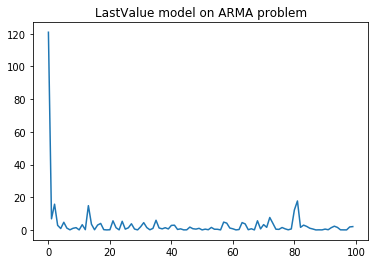

In [0]:
# create problem instance and specify loss
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
x = problem.initialize(p, q)
mse = lambda y_true, y_pred: (y_true - y_pred)**2

# create model
model = ctsb.model("LastValue")
model.initialize()

# run model for T time-steps
results = []
for i in range(T):
    y_pred = model.predict(x)
    y_true = problem.step()
    loss = mse(y_true, y_pred)
    results.append(loss)
    model.update(loss)
    x = y_true

# plot model performance
plt.plot(results)
plt.title("LastValue model on ARMA problem")
plt.show()


# The Problem and Model Registry
Each of the Problem and Model classes included in CTSB are inserted into a global registry, which is dict from a unique string to the Problem/Model class corresponding to the string. The registry supports versioning, so that multiple versions of a certain Problem/Model can be referenced. For example, the id "ARMA-v0" is the registry id for version 0 of the ARMA problem. The previous example shows how to create instances of problem and model via the corresponding registry ids. A comprehensive list of all Problem and Model ids can be printed by printing out the keys of the global registries: problem_registry and model_registry, as demonstrated below.

In [0]:
print(ctsb.problem_registry.list_ids())
print(ctsb.model_registry.list_ids())

['Random-v0', 'ARMA-v0', 'LDS-v0', 'RNN-v0', 'LSTM-v0', 'Pendulum-v0', 'SP500-v0', 'UCIIndoor-v0', 'Crypto-v0']
['LastValue', 'AutoRegressor', 'PredictZero', 'KalmanFilter', 'TD3', 'ShootingMethod']


# Creating and Registering Custom Models
In order to add a new algorithm to the registry, you must first implement a CustomModel object that adheres to the specifications of the other CTSB models. As long as your class inherits the ctsb CustomClass object and has the three core CTSB Model methods implemented — *initialize*, *predict*, and *update* — the class will interface as expected with all the other features in the framework. These methods are:

*   Initialize — initializes model parameters and other local variables, and is called at the beginning of every problem run
*   Predict — a function that takes an input observation 'x' and returns a prediction which can depend on the parameters defined in initialize
*   Update — which takes the true label with respect to the last observed value 'x' and performs some correction over the initialized parameters.

The output of the predict method will vary depending on the task of your model. Below, we implement a trivial last-value model named MyModel.

In [0]:
class MyModel(ctsb.CustomModel):
  
  def initialize(self):
    pass
  
  def predict(self, x):
    return x
  
  def update(self, y_true):
    pass

CTSB comes with a built in ```register_custom_model``` method that allows users to register model classes with custom names.

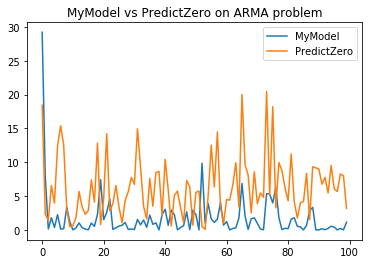

In [0]:
# add MyModel to the model registry
ctsb.register_custom_model(MyModel, "NameOfMyModel")

# we can now use it as with any other model
my_model = ctsb.model("NameOfMyModel")
my_model.initialize()

# test model on ARMA problem and compare to PredictZero
T = 100
p, q = 3, 3
problem = ctsb.problem("ARMA-v0")
x = problem.initialize(p, q)
mse = lambda y_true, y_pred: (y_true - y_pred)**2
pz_model = ctsb.model("PredictZero")
pz_model.initialize()

my_results = []
pz_results = []
for i in range(T):
    my_y_pred = my_model.predict(x)
    pz_y_pred = pz_model.predict(x)
    y_true = problem.step()
    my_loss = mse(y_true, my_y_pred)
    pz_loss = mse(y_true, pz_y_pred)
    my_results.append(my_loss)
    pz_results.append(pz_loss)
    my_model.update(y_true)
    pz_model.update(y_true)
    x = y_true

# plot model performance
plt.plot(my_results, label="MyModel")
plt.plot(pz_results, label="PredictZero")
plt.legend()
plt.title("MyModel vs PredictZero on ARMA problem")
plt.show()


Our class can now be find in the registry as well. 

In [0]:
print(ctsb.model_registry.list_ids())

['LastValue', 'AutoRegressor', 'PredictZero', 'KalmanFilter', 'TD3', 'ShootingMethod', 'NameOfMyModel']


# The Experiment Class
The Experiment class should be thought of as a sort of engine that allows the automated combination of various models against various problems. It supports plotting the loss functions for the various (problem, model) trials. The initialize method takes 3 required parameters (the loss function, a dict from problem_id to parameters, a dict from model_id to parameters) which are self-explanatory and one optional parameter (problem_to_models) which specifies which models to test against each problem. If problem_to_models is unspecified, the experiment class assumes that every model should be tested against every problem. Below, we demonstrate two ways to initialize experiment.

  2%|▏         | 2/100 [00:00<00:09, 10.19it/s]

running experiment: <LastValue Model> on <ARMA Problem>


  2%|▏         | 2/100 [00:00<00:09, 10.84it/s]

running experiment: <PredictZero Model> on <ARMA Problem>


100%|██████████| 100/100 [00:00<00:00, 21059.97it/s]


running experiment: <LastValue Model> on <SP500 Problem>
running experiment: <PredictZero Model> on <SP500 Problem>


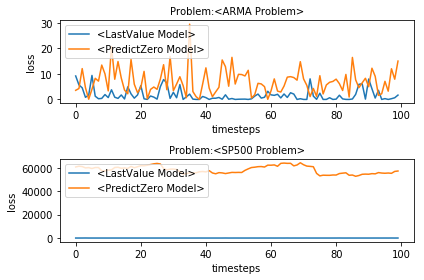

  2%|▏         | 2/100 [00:00<00:09, 10.75it/s]

running experiment: <LastValue Model> on <ARMA Problem>


100%|██████████| 100/100 [00:00<00:00, 45749.39it/s]


running experiment: <PredictZero Model> on <SP500 Problem>


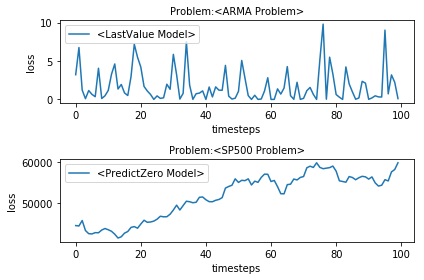

In [0]:
from ctsb.utils.experiment import Experiment

# test without problem_to_models
steps = 100
exp = Experiment()
MSE = lambda y_true, y_pred: (y_true - y_pred)**2
problem_to_params = {'ARMA-v0' : {'p':3, 'q':3}, 
                      'SP500-v0' : {}}
model_to_params = {'LastValue': {},
                    'PredictZero': {}}
exp.initialize(MSE, problem_to_params, model_to_params)
exp.run_all_experiments(steps)
exp.plot_all_problem_results()

# test with problem_to_models
exp = Experiment()
problem_to_models = {'ARMA-v0' : ['LastValue'],
                      'SP500-v0' : ['PredictZero']}
exp.initialize(MSE, problem_to_params, model_to_params, problem_to_models)
exp.run_all_experiments(steps)
exp.plot_all_problem_results()


# Random Seeding
As you may have observed from the beginning of the notebook, CTSB utilizes seeding implemented by jax.random in order to enforce reproducibility of experiment results. By setting a global random key at the beginning of a program, right after ctsb is imported, the random number generators used in all the problems and models become deterministic. Below, we demonstrate how to reproduce the same experiment twice by calling set_key().

In [0]:
import jax.random as random
from ctsb.utils.random import generate_key, set_key

key = 2019 # arbitrary integer value
T = 100
n, m, d = 5, 1, 10
problem = ctsb.problem("LDS-v0")

# set the key and run experiment once
set_key(key)
problem.initialize(n, m, d)
test_output = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output.append(problem.step(u))

# use the same key and run again
set_key(key)
problem.initialize(n, m, d)
test_output_2 = []
for t in range(T):
    u = random.normal(generate_key(),shape=(n,))
    test_output_2.append(problem.step(u))

# plot results
fig, ax = plt.subplots(nrows=2, ncols=1)
ax[0].plot(test_output)
ax[1].plot(test_output_2)

fig.tight_layout()
plt.show()

You are now ready to benchmark your algorithm of choice using CTSB!